In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import cv2

import os
from glob import glob
from tqdm.notebook import tqdm_notebook as tqdm
from joblib import delayed, Parallel

import albumentations as A
from sklearn.model_selection import train_test_split

from src.utils import tqdm_joblib, seed_everything

In [3]:
SEED = 17112000
SPLITS_ROOT = 'data/splits'
IMAGES_ROOT = 'data/Images'

In [4]:
seed_everything(SEED)

In [5]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [6]:
train_df.head()

image_id                        bbox  category_id      id
0  id_w55q2qr62fsk    [122.0, 1.0, 42.0, 30.0]          2.0  6356.0
1  id_fvldv7o1kn9d  [500.0, 141.0, 74.0, 70.0]          2.0  2305.0
2  id_5d1r9l1jp7b5  [304.0, 525.0, 54.0, 58.0]          2.0   238.0
3  id_45qru79t6s4n  [187.0, 298.0, 44.0, 56.0]          2.0   921.0
4  id_84cjf2pbqmtv  [349.0, 721.0, 58.0, 59.0]          2.0  1362.0

In [7]:
test_df.head()

image_id
0  id_uawi0k5spci5
1  id_ba566jv4xzln
2  id_q4odggcgnc77
3  id_4lrqmvmmgier
4  id_sqadni8gqzao

In [8]:
submission = pd.read_csv('SampleSubmission.csv')
submission.head()

image_id  Target
0  id_uawi0k5spci5_1       0
1  id_uawi0k5spci5_2       0
2  id_uawi0k5spci5_3       0
3  id_ba566jv4xzln_1       0
4  id_ba566jv4xzln_2       0

In [9]:
train_df.shape, np.unique(train_df.image_id).shape

((26156, 4), (4772,))

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
colors = {1 : "red", 2 : "blue", 3 : "yellow"}

df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')

for i, (key, item) in enumerate(grouped_df):
    group = grouped_df.get_group(key)

    file_name = f"{group.iloc[0].image_id}.tif"
    image = rasterio.open(os.path.join(IMAGES_ROOT, file_name)).read().transpose((1,2,0))

    axes[i//3, i%3].imshow(image)
    axes[i//3, i%3].set_title(group.iloc[0].image_id)
    for j in range(group.shape[0]):
        bbox = eval(group.iloc[j].bbox)
        category = group.iloc[j].category_id

        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[2], linewidth=1.5, edgecolor=colors[category], facecolor='none')
        axes[i//3, i%3].add_patch(rect)

    if i == 8:
        break

In [33]:
colors = {1 : "red", 2 : "blue", 3 : "yellow"}
def show_image_with_bboxes(image, bboxes, categories):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.imshow(image)
    for bbox, category in zip(bboxes, categories):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[2], linewidth=1.5, edgecolor=colors[category], facecolor='none')
        ax.add_patch(rect)

## Get Splits

In [55]:
def get_shape(file_name):
    path = os.path.join(IMAGES_ROOT, f"{file_name}.tif")
    shape = cv2.imread(path).shape[:2]
    return (file_name, shape)

def is_image_corrupted(file_name, low_threshold=5, high_threshold=250, corruption_threshold=0.2, return_mask=False):
    image = cv2.imread(os.path.join(IMAGES_ROOT, f'{file_name}.tif'))
    low_corrupted = (image < low_threshold).all(axis=-1)
    high_corrupted = (image > high_threshold).all(axis=-1)
    total_corrupted = low_corrupted | high_corrupted
    corruption_mask = low_corrupted | high_corrupted
    
    corrupted_percentage = corruption_mask.astype(np.float32).mean()
    is_corrupted = corrupted_percentage > corruption_threshold

    if return_mask:
        return file_name, is_corrupted, corruption_mask.astype(np.uint8)
    else:
        return file_name, is_corrupted

In [57]:
train_df = pd.read_csv('data/Train.csv')
file_names = np.unique(train_df.image_id)

with tqdm_joblib(tqdm(desc="Processing", total=file_names.shape[0])) as progress_bar:
    shapes = Parallel(n_jobs=-1)(delayed(get_shape)(file_name) for file_name in file_names)

shapes = pd.DataFrame(shapes, columns=['image_id', 'img_shape'])

with tqdm_joblib(tqdm(desc="Processing", total=file_names.shape[0])) as progress_bar:
    corruption = Parallel(n_jobs=-1)(delayed(is_image_corrupted)(file_name) for file_name in file_names)

corruption = pd.DataFrame(corruption, columns=['image_id', 'is_corrupted'])

Processing:   0%|          | 0/4772 [00:00<?, ?it/s]

Processing:   0%|          | 0/4772 [00:00<?, ?it/s]

In [58]:
train_df = train_df.join(shapes.set_index('image_id'), on='image_id')
train_df = train_df.join(corruption.set_index('image_id'), on='image_id')
train_df_unique = train_df.drop_duplicates(subset=['image_id', 'img_shape'])

In [59]:
train_ids, valid_ids = train_test_split(train_df_unique.image_id, test_size=0.2, shuffle=True, stratify=train_df_unique.img_shape)

train = train_df[train_df.image_id.isin(train_ids)]
valid = train_df[train_df.image_id.isin(valid_ids)]
train.to_csv(os.path.join(SPLITS_ROOT, 'train.csv'), index=None)
valid.to_csv(os.path.join(SPLITS_ROOT, 'valid.csv'), index=None)

In [60]:
train_df = train_df[~train_df.bbox.isna()]
train_ids, valid_ids = train_test_split(train_df_unique.image_id, test_size=0.2, shuffle=True, stratify=train_df_unique.img_shape)

train = train_df[train_df.image_id.isin(train_ids)]
valid = train_df[train_df.image_id.isin(valid_ids)]
train.to_csv(os.path.join(SPLITS_ROOT, 'train_bbox_only.csv'), index=None)
valid.to_csv(os.path.join(SPLITS_ROOT, 'valid_bbox_only.csv'), index=None)

In [61]:
train_df = train_df[~train_df.bbox.isna()]
train_df = train_df[~train_df.is_corrupted]
train_ids, valid_ids = train_test_split(train_df_unique.image_id, test_size=0.2, shuffle=True, stratify=train_df_unique.img_shape)

train = train_df[train_df.image_id.isin(train_ids)]
valid = train_df[train_df.image_id.isin(valid_ids)]
train.to_csv(os.path.join(SPLITS_ROOT, 'train_bbox_only_nc.csv'), index=None)
valid.to_csv(os.path.join(SPLITS_ROOT, 'valid_bbox_only_nc.csv'), index=None)

In [62]:
train.iloc[:100].to_csv(os.path.join(SPLITS_ROOT, 'test_launch.csv'), index=None)

## CSV to YAML COCO

In [9]:
import json
from PIL import Image

def to_coco(df, dst):
    df.dropna(inplace=True)
    df['bbox'] = df['bbox'].apply(eval)

    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "Other"},
            {"id": 2, "name": "Tin"},
            {"id": 3, "name": "Thatch"}
        ]
    }
    index_dict = {}
    i = 0
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        index_dict[image_id] = i
        i += 1


    # Helper function to get image dimensions
    def get_image_dimensions(image_path):
        with Image.open(image_path) as img:
            return img.width, img.height


    # Populate images section
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        file_name = f"{image_id}.tif"  # Adjust the extension if needed
        image_path = os.path.join(IMAGES_ROOT, file_name)
        width, height = get_image_dimensions(image_path)
        coco_format["images"].append({
            "id": index_dict[image_id],
            "file_name": file_name,
            "width": width,
            "height": height
        })

    # Annotations
    for index, row in df.iterrows():
        annotation = {
            "id": index,
            "image_id": index_dict[row["image_id"]],
            "category_id": int(row["category_id"]),
            "bbox": row["bbox"],
            "area": row["bbox"][2] * row["bbox"][3],  # width * height
            "iscrowd": 0,
            "segmentation": []  # Empty if not using segmentation
        }
        coco_format["annotations"].append(annotation)

    # Save to JSON
    with open(dst, 'w') as f:
        json.dump(coco_format, f, indent=4)

In [10]:
for csv_file in tqdm(glob('data/splits/*.csv')):
    df = pd.read_csv(csv_file)
    dst = f"{os.path.splitext(csv_file)[0]}.json"

    to_coco(df, dst)

  0%|          | 0/7 [00:00<?, ?it/s]

## Get maximum IoU between GT bboxes across all images

In [75]:
def convert_coco_to_pascal(bbox):
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]

def calculate_iou_coco(boxA, boxB):
    if boxA[2] == 0 or boxA[3] == 0 or boxB[2] == 0 or boxB[3] == 0:
        return 0

    boxA = convert_coco_to_pascal(boxA)
    boxB = convert_coco_to_pascal(boxB)
    
    dx = min(boxA[2], boxB[2]) - max(boxA[0], boxB[0]) + 1
    dy = min(boxA[3], boxB[3]) - max(boxA[1], boxB[1]) + 1

    if dy < 0 or dx < 0:
        return 0.0

    overlap_area = dx * dy
    union_area = ((boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1) + (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1) - overlap_area)

    return overlap_area / union_area


In [77]:
def get_max_iou(bboxes, categories):
    max_iou = 0
    for i, (boxA, catA) in enumerate(zip(bboxes, categories)):
        for j, (boxB, catB) in enumerate(zip(bboxes, categories)):
            if i >= j or catA != catB:
                continue
            iou = calculate_iou_coco(boxA, boxB)
            max_iou = max(max_iou, iou)
    return max_iou

df = pd.concat([pd.read_csv(os.path.join(SPLITS_ROOT, 'train_bbox_only.csv')), pd.read_csv(os.path.join(SPLITS_ROOT, 'valid_bbox_only.csv'))])
grouped = df.groupby("image_id")
all_bboxes = [(grouped.get_group(image_id).bbox.apply(eval).to_list(), grouped.get_group(image_id).category_id.apply(int).to_list()) for image_id in np.unique(df.image_id)]
with tqdm_joblib(tqdm(desc="Processing", total=len(all_bboxes))) as progress_bar:
    max_iou_results = Parallel(n_jobs=-1)(delayed(get_max_iou)(image_bboxes, image_categories) for image_bboxes, image_categories in all_bboxes)

max_iou_across_images = max(max_iou_results)
print("Maximum IoU across all bounding boxes on all images:", max_iou_across_images)


Processing:   0%|          | 0/2465 [00:00<?, ?it/s]

Maximum IoU across all bounding boxes on all images: 0.9565217391304348


In [83]:
import torch
torch.tensor([1,2,3]).tolist()

[1, 2, 3]

## Get bbox shape dist.

In [71]:
def get_bbox_shapes(bboxes):
    return [(w,h) for _, _, w, h in bboxes]

df = pd.concat([pd.read_csv(os.path.join(SPLITS_ROOT, 'train_bbox_only.csv')), pd.read_csv(os.path.join(SPLITS_ROOT, 'valid_bbox_only.csv'))])
grouped = df.groupby("image_id")
all_bboxes = [grouped.get_group(image_id).bbox.apply(eval).to_list() for image_id in np.unique(df.image_id)]
with tqdm_joblib(tqdm(desc="Processing", total=len(all_bboxes))) as progress_bar:
    bboxes_shapes = Parallel(n_jobs=-1)(delayed(get_bbox_shapes)(image_bboxes) for image_bboxes in all_bboxes)


Processing:   0%|          | 0/2465 [00:00<?, ?it/s]

In [76]:
bboxes_shapes_ = []
for list_ in bboxes_shapes:
    bboxes_shapes_.extend(list_)

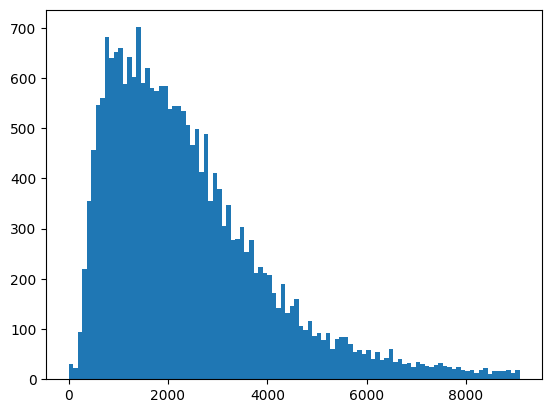

In [86]:
areas = np.array(sorted(bboxes_shapes_, key=lambda x: np.prod(x))).prod(axis=1)
np.quantile(areas, q=0.95)
_ = plt.hist(areas[areas < 9086.0], bins=100)

## Check bboxes for dublicates

### Regarding the category

In [22]:
from ast import literal_eval

df = pd.read_csv('Train.csv')
df = df[~df.bbox.isna()]
df.bbox = df.bbox.apply(lambda box: tuple(eval(box)))
grouped = df.groupby(['image_id', 'bbox'])
duplicates = grouped.filter(lambda x: x['category_id'].nunique() > 1)

if not duplicates.empty:
    print("Found bounding boxes with different categories on the same image:")
    print(duplicates[['image_id', 'bbox', 'category_id']])
else:
    print("No duplicates found.")

No duplicates found.


## Maximum number of bboxes per image

In [29]:
df = pd.read_csv('data/Train.csv')
df = df[~df.bbox.isna()]

max_num_bboxes = 0
max_key = ''

for key, item in df.groupby('image_id'):
    num_bboxes = item.shape[0]
    if num_bboxes > max_num_bboxes:
        max_num_bboxes = num_bboxes
        max_key = key

In [30]:
max_key

'id_0v85a76qcx9m'

## Custom Faster R-CNN loss

In [12]:
import torch.nn.functional as F
import torch
def fastrcnn_loss_custom(focal_loss):
    def fastrcnn_loss(class_logits, box_regression, labels, regression_targets):
        # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
        """
        Computes the loss for Faster R-CNN.

        Args:
            class_logits (Tensor)
            box_regression (Tensor)
            labels (list[BoxList])
            regression_targets (Tensor)

        Returns:
            classification_loss (Tensor)
            box_loss (Tensor)
        """
        labels = torch.cat(labels, dim=0)
        regression_targets = torch.cat(regression_targets, dim=0)

        classification_loss = focal_loss(class_logits, labels)

        # get indices that correspond to the regression targets for
        # the corresponding ground truth labels, to be used with
        # advanced indexing
        sampled_pos_inds_subset = torch.where(labels > 0)[0]
        labels_pos = labels[sampled_pos_inds_subset]
        N, num_classes = class_logits.shape
        box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

        box_loss = F.smooth_l1_loss(
            box_regression[sampled_pos_inds_subset, labels_pos],
            regression_targets[sampled_pos_inds_subset],
            beta=1 / 9,
            reduction="sum",
        )
        box_loss = box_loss / labels.numel()

        return classification_loss, box_loss
    return fastrcnn_loss

focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='FocalLoss',
	gamma=2,
)
# x, y = torch.randn(10, 2), (torch.rand(10) > .5).long()
# loss = focal_loss(x, y)

from torchvision.models.detection import roi_heads
roi_heads.fastrcnn_loss = fastrcnn_loss_custom(focal_loss)

Using cache found in /trinity/home/georgy.popandopulo/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [6]:
import gc

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, FasterRCNN_ResNet50_FPN_Weights

from src.data.datasets import RoofsDataset
from src.network import fasterrcnn_resnet_fpn
from src.data.utils import collate_fn

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
network = fasterrcnn_resnet_fpn(backbone_name='resnet50', weights=weights, pretrained_backbone=True)
in_features = network.roi_heads.box_predictor.cls_score.in_features
network.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
network = network.to(device)
_ = network.train()

In [9]:
train_split = pd.read_csv(f'data/splits/train_bbox_only_nc.csv')
valid_split = pd.read_csv(f'data/splits/valid_bbox_only_nc.csv')

loaders_params = {
    "root"        : 'data/Images',
    "train_split" : train_split,
    "valid_split" : valid_split,
    "batch_size"  : 1, 
    "collate_fn"  : collate_fn,
    "transforms"  : [],
    "cpu"         : True
}

train_loader, valid_loader = RoofsDataset.get_dataloaders(**loaders_params)

In [13]:
torch.cuda.empty_cache()
gc.collect()

for i, (features, targets, rgbs,_) in enumerate(valid_loader):

    features = [feature.to(device) for feature in features]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]   

    losses = network(features, targets)
    print('losses', losses)

    break


losses {'loss_classifier': tensor(0.6774, grad_fn=<MeanBackward0>), 'loss_box_reg': tensor(0.2573, grad_fn=<DivBackward0>), 'loss_objectness': tensor(3.2700, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2646, grad_fn=<DivBackward0>)}


In [28]:
losses

{'loss_classifier': tensor(1.2228, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.2845, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.4230, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0197, device='cuda:0', grad_fn=<DivBackward0>)}

## NMS test

In [25]:
df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')
example_image = grouped_df.get_group("id_02f9pbs0slgu")

In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, FasterRCNN_ResNet50_FPN_Weights

In [5]:
from src.data.datasets import RoofsDataset
from src.network import fasterrcnn_resnet_fpn
from src.data.utils import collate_fn

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
network = fasterrcnn_resnet_fpn(backbone_name='resnet50', weights=weights, pretrained_backbone=True)
in_features = network.roi_heads.box_predictor.cls_score.in_features
network.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
network = network.to(device)

checkpoint = torch.load('exp/ARM-5/best.pth')
network.load_state_dict(checkpoint['PARAMS'])
a  = network.eval()

In [8]:
train_split = pd.read_csv(f'splits/train_bbox_only_nc.csv')
valid_split = pd.read_csv(f'splits/valid_bbox_only_nc.csv')

loaders_params = {
    "root"        : 'Images',
    "train_split" : train_split,
    "valid_split" : valid_split,
    "batch_size"  : 8, 
    "collate_fn"  : collate_fn,
    "transforms"  : [],
    "cpu"         : True
}

train_loader, valid_loader = RoofsDataset.get_dataloaders(**loaders_params)

In [15]:
torch.cuda.empty_cache()
I = 5
with torch.no_grad():
    for i, (features, targets, rgbs) in enumerate(valid_loader):

        if i != I:
            continue

        features = [feature.to(device) for feature in features]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]   

        predictions_non_nms = network(features)
        predictions_non_nms = [{key : value.cpu() for key, value in prediction.items()} for prediction in predictions_non_nms]

        if i == I:
            break

In [10]:
def convert_coco_to_pascal(bbox):
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]

def area(box):
    dx = box[2] - box[0]
    dy = box[3] - box[1]

    return max(dx, 0) * max(dy, 0)

def intersection(boxA, boxB):
    dx = min(boxA[2], boxB[2]) - max(boxA[0], boxB[0])
    dy = min(boxA[3], boxB[3]) - max(boxA[1], boxB[1])

    return max(dx, 0) * max(dy, 0)

def union(boxA, boxB):
    return ((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) + (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) - intersection(boxA, boxB))

def nested(boxA, boxB):
    return intersection(boxA, boxB) == min(area(boxA), area(boxB))

def IoU(boxA, boxB):
    return intersection(boxA, boxB) / union(boxA, boxB)

In [105]:
bboxes = [p['boxes'].tolist() for p in predictions_non_nms][0]
scores = [p['scores'].tolist() for p in predictions_non_nms][0]
labels = [p['labels'].tolist() for p in predictions_non_nms][0]

In [106]:
best_bbox_id = np.argmax(scores)
good_bboxes = [bboxes[best_bbox_id]]
good_labels = [labels[best_bbox_id]]
bboxes.pop(best_bbox_id)
scores.pop(best_bbox_id)
labels.pop(best_bbox_id)

iou_thr = 0.35
trash_thr = 0.01
skip = False

for i, bbox in enumerate(bboxes):
    for j, good_bbox in enumerate(good_bboxes):
        if IoU(bbox, good_bbox) >= iou_thr or nested(bbox, good_bbox) or scores[i] < trash_thr:
            skip = True
            break
    if skip:
        skip = False
        continue
    else:
        good_bboxes.append(bbox)
        good_labels.append(labels[i])
        bboxes.pop(i)
        scores.pop(i)
        labels.pop(i)
        i = i - 1

In [107]:
def iou_with_nested_single(boxesA, boxB):
    max_xy = torch.min(boxesA[:, 2:], boxB[2:])
    min_xy = torch.max(boxesA[:, :2], boxB[:2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    inter_area = inter[:, 0] * inter[:, 1]
    
    areaA = ((boxesA[:, 2] - boxesA[:, 0]) * (boxesA[:, 3] - boxesA[:, 1]))
    areaB = ((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    union = areaA + areaB - inter_area
    
    iou = inter_area / union
    
    boxB_inside_A = (boxesA[:, :2] <= boxB[:2]) & (boxesA[:, 2:] >= boxB[2:])
    A_inside_boxB = (boxB[:2] <= boxesA[:, :2]) & (boxB[2:] >= boxesA[:, 2:])
    iou[boxB_inside_A.all(dim=1) | A_inside_boxB.all(dim=1)] = 1
    
    return iou

In [145]:
scores, bboxes = predictions_non_nms[0]['scores'], predictions_non_nms[0]['boxes']
categories = predictions_non_nms[0]['labels']
idxs = torch.argsort(scores, descending=True)
scores = scores[idxs]
bboxes = bboxes[idxs]

keep = torch.zeros_like(scores, dtype=torch.bool)
keep[0] = True

for i in idxs:
    if not keep[i]:
        ious = iou_with_nested_single(bboxes[keep], bboxes[i])
        if (ious < iou_thr).all() and scores[i] > trash_thr:
            keep[i] = True


In [146]:
keep

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False, False, False, False,  True, False, False, False,  True,  True,
        False, False, False, False, False, False,  True, False, False, False,
         True, False, False])

In [208]:
def iou_with_inside_checks(boxesA, boxesB):
    inter_max_xy = torch.min(boxesA[:, None, 2:], boxesB[None, :, 2:])
    inter_min_xy = torch.max(boxesA[:, None, :2], boxesB[None, :, :2])
    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]

    areaA = ((boxesA[:, 2] - boxesA[:, 0]) * (boxesA[:, 3] - boxesA[:, 1])).unsqueeze(1)
    areaB = ((boxesB[:, 2] - boxesB[:, 0]) * (boxesB[:, 3] - boxesB[:, 1])).unsqueeze(0)

    union = areaA + areaB - inter_area
    iou = inter_area / union

    # Check if intersection area is close to the area of one of the boxes
    ratioA = inter_area / areaA
    ratioB = inter_area / areaB
    is_close_to_one = (ratioA > inter_thr) | (ratioB > inter_thr)

    # Adjust IoU based on the size check
    iou[is_close_to_one] = 1

    # A_inside_B = (boxesA[:, None, :2] <= boxesB[None, :, :2]) & (boxesA[:, None,  2:] >= boxesB[None, :, 2:])
    # B_inside_A = (boxesB[None, :, :2] <= boxesA[:, None, :2]) & (boxesB[None, :,  2:] >= boxesA[:, None, 2:])
    # A_inside_B_all = A_inside_B.all(dim=-1)
    # B_inside_A_all = B_inside_A.all(dim=-1)

    # iou[A_inside_B_all | B_inside_A_all.transpose(0, 1)] = 1

    torch.diagonal(iou, 0).fill_(0)
    return iou.squeeze()

iou_thr = 0.35
trash_thr = 0.01
inter_thr = 0.8

# Your data
# predictions_non_nms = [your_data_here]  # Replace with your actual data
scores, bboxes = predictions_non_nms[0]['scores'], predictions_non_nms[0]['boxes']
categories = predictions_non_nms[0]['labels']

# Sort by scores
idxs = torch.argsort(scores, descending=True)
scores_ = scores[idxs]
bboxes_ = bboxes[idxs]
categories_ = categories[idxs]

# Precompute all IoUs - adjust this line based on your actual IoU computation
ious = iou_with_inside_checks(bboxes_, bboxes_)

# IoU thresholding
is_above_iou_thr = ious > iou_thr
is_above_iou_thr.fill_diagonal_(0)  # Exclude self-comparison

# Score thresholding
is_above_score_thr = scores_ > trash_thr

# Combine conditions and apply
# This logic might need to be adjusted based on your specific NMS algorithm needs
keep_mask = torch.zeros(scores_.size(0), dtype=torch.bool, device=scores_.device)
keep_mask[0] = True

# Iterate over sorted boxes (by score, descending)
for i in range(scores_.size(0)):
    if is_above_score_thr[i] and not keep_mask[i]:  # Check score threshold
        # Compare current box only with boxes having higher scores that are kept
        iou_with_higher_scored_kept_boxes = ious[i, keep_mask]
        # If IoU with all higher-scored kept boxes is below the threshold, keep this box
        if not iou_with_higher_scored_kept_boxes.gt(iou_thr).any():
            keep_mask[i] = True

# Apply the final keep mask to filter scores, boxes, and categories
final_scores = scores_[keep_mask]
final_bboxes = bboxes_[keep_mask]
final_categories = categories_[keep_mask]


In [189]:
torch.set_printoptions(profile="full")
# print(ious)

(-0.5, 499.5, 499.5, -0.5)

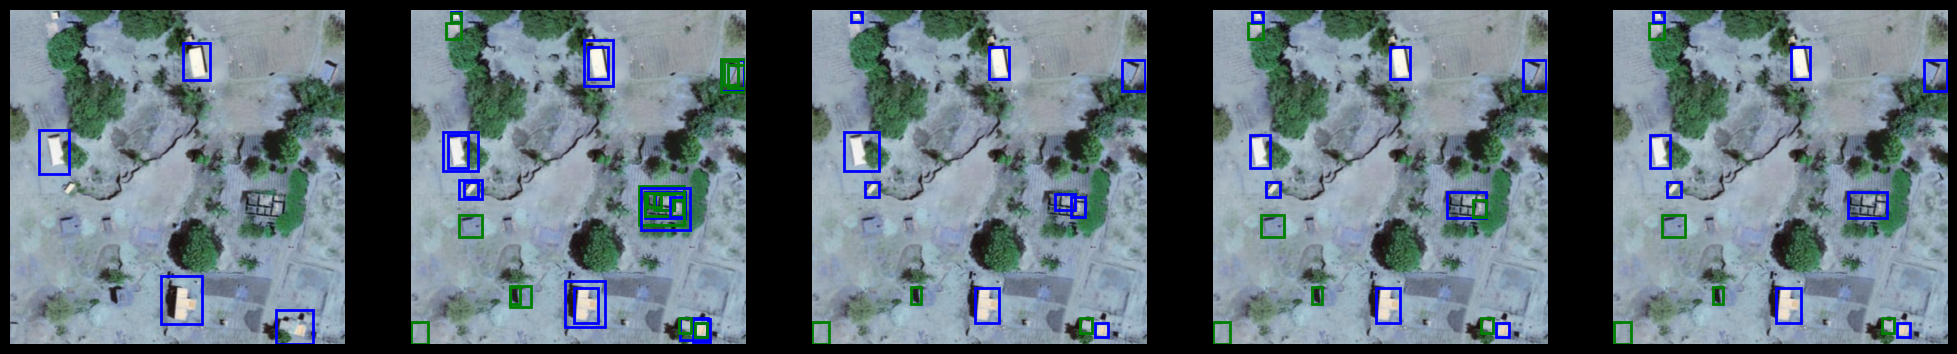

In [209]:
category_color_map = {1 : "red", 2 : "blue", 3 : "green"}
category_name_map =  {1 : "Other", 2 : "Tin", 3 : "Thatch"}

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

axs[0].imshow(rgbs[0])
axs[1].imshow(rgbs[0])
axs[2].imshow(rgbs[0])
axs[3].imshow(rgbs[0])
axs[4].imshow(rgbs[0])

for box, category in zip(targets[0]['boxes'], targets[0]['labels']):
    box = box.cpu().numpy()
    category = category.cpu().item()
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min
    
    color = category_color_map.get(category, 'black')
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=color, facecolor='none')
    axs[0].add_patch(rect)

for box, category in zip(predictions_non_nms[0]['boxes'], predictions_non_nms[0]['labels']):
    box = box.cpu().numpy()
    category = category.cpu().item()
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min
    
    color = category_color_map.get(category, 'black')
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=color, facecolor='none')
    axs[1].add_patch(rect)

for box, category in zip(good_bboxes, good_labels):
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min
    
    color = category_color_map.get(category, 'black')
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=color, facecolor='none')
    axs[2].add_patch(rect)
    
bboxes, categories = bboxes[keep], categories[keep]
for box, category in zip(bboxes, categories):
    box = box.cpu().numpy()
    category = category.cpu().item()
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min
    
    color = category_color_map.get(category, 'black')
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=color, facecolor='none')
    axs[3].add_patch(rect)

for box, category in zip(final_bboxes, final_categories):
    box = box.cpu().numpy()
    category = category.cpu().item()
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min
    
    color = category_color_map.get(category, 'black')
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=color, facecolor='none')
    axs[4].add_patch(rect)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

In [100]:
from ensemble_boxes import *

prediction={
     'boxes': torch.tensor([[164.0904, 430.6341, 205.3053, 491.7847],
                            [172.1443, 386.1515, 214.7098, 439.0793],
                            [162.8006, 398.8545, 204.7550, 458.8336],
                            [189.1458, 452.0859, 222.4915, 491.3753],
                            [168.5587, 441.8985, 214.2169, 491.3627],
                            [165.8021, 407.0647, 206.2039, 450.5518],
                            [180.1139, 414.3625, 221.2982, 455.7961],
                            [165.4650, 352.2438, 204.8265, 386.9186],
                            [189.5171, 450.5505, 224.6197, 491.2152],
                            [167.1739, 455.3083, 197.0390, 495.0787],
                            [179.5523, 415.0593, 225.0787, 455.2281],
                            [168.4929, 418.3306, 213.9413, 468.3598],
                            [318.8755,  19.2481, 344.4881,  43.3747],
                            [179.7794, 413.8855, 220.2423, 457.7352],
                            [170.6396, 387.0128, 213.3923, 440.1222],
                            [167.3804, 420.6959, 214.7517, 467.0379],
                            [170.9972, 387.4221, 216.2587, 438.0562],
                            [167.0711, 454.7218, 199.0471, 496.0938],
                            [188.3979, 451.5073, 222.4274, 492.5879],
                            [322.7314,  18.4351, 346.9096,  47.5985],
                            [313.7731,  11.3896, 341.1308,  40.1932],
                            [167.8239, 404.4479, 210.3771, 461.1182],
                            [250.7787, 140.4857, 282.6726, 166.8529],
                            [168.6096, 428.9743, 211.5053, 478.4532],
                            [183.6333, 381.1337, 220.0013, 415.6695],
                            [182.1358, 422.3499, 223.7201, 483.6554],
                            [394.6922, 469.0452, 405.5321, 491.6824],
                            [437.6689, 289.2993, 457.3781, 333.1555],
                            [336.1444, 358.8720, 358.2661, 387.4191],
                            [312.8951,  12.4852, 340.1799,  42.4752],
                            [250.7055, 140.4949, 282.8484, 166.6849],
                            [174.6343, 340.1406, 221.3841, 394.3916],
                            [312.8532, 322.6429, 332.6594, 355.8706],
                            [436.1726, 293.1230, 456.0745, 342.5861],
                            [441.8798, 188.4603, 466.4193, 218.8938],
                            [395.3102, 472.4976, 406.5247, 492.6707],
                            [312.7917,  13.2133, 339.8693,  43.0509],
                            [394.8483, 466.9691, 406.9714, 491.4918],
                            [248.3808, 141.0257, 281.9129, 168.1343],
                            [181.8051, 423.5623, 228.3916, 482.9276],
                            [313.8857, 322.7492, 332.8556, 358.9691],
                            [166.2607, 448.4949, 204.3631, 495.3755],
                            [165.3812, 351.2862, 205.0961, 386.6653],
                            [315.6697, 444.3265, 334.2731, 475.8591],
                            [180.8530, 422.6086, 223.0186, 487.9582],
                            [378.5436, 128.6835, 411.2830, 158.6104]]), 
     'labels': torch.tensor([2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 1, 1, 3, 3, 3, 1, 2, 3, 1, 2, 1, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 2]), 
     'scores': torch.tensor([0.0978, 0.0915, 0.0897, 0.0879, 0.0859, 0.0849, 0.0822, 0.0792, 0.0791,
                                0.0756, 0.0749, 0.0729, 0.0716, 0.0710, 0.0689, 0.0683, 0.0678, 0.0678,
                                0.0662, 0.0655, 0.0640, 0.0636, 0.0636, 0.0631, 0.0615, 0.0598, 0.0592,
                                0.0586, 0.0581, 0.0564, 0.0560, 0.0556, 0.0553, 0.0550, 0.0548, 0.0544,
                                0.0543, 0.0541, 0.0519, 0.0516, 0.0513, 0.0510, 0.0508, 0.0507, 0.0506,
                                0.0503])
}

prediction['boxes'] /= 500
prediction['boxes'] = prediction['boxes'].clip(min=0, max=1)

boxes, scores, labels = soft_nms([prediction['boxes'].tolist()], 
                                [prediction['scores'].tolist()],
                                [prediction['labels'].tolist()], 
                                iou_thr=0.35, 
                                sigma=0.1, 
                                thresh=0.01)

In [102]:
boxes * 500

array([[179.77941036, 413.88550401, 220.24229169, 457.73521066],
       [188.39789927, 451.50730014, 222.42739797, 492.5878942 ],
       [436.17260456, 293.12297702, 456.07450604, 342.5861001 ],
       [395.3102231 , 472.49758244, 406.52468801, 492.67068505],
       [312.79167533,  13.21330015, 339.86929059,  43.0509001 ],
       [248.38079512, 141.02569222, 281.91289306, 168.134287  ],
       [170.63960433, 387.01277971, 213.39230239, 440.12218714],
       [166.2606895 , 448.49491119, 204.36309278, 495.37548423],
       [164.09039497, 430.63408136, 205.3052932 , 491.78469181],
       [172.14430869, 386.1514926 , 214.70978856, 439.07931447],
       [165.46499729, 352.24381089, 204.82650399, 386.91860437],
       [322.7314055 ,  18.43510009, 346.90961242,  47.5984998 ],
       [250.77870488, 140.48570395, 282.67261386, 166.85290635],
       [189.14580345, 452.08591223, 222.49150276, 491.37529731],
       [394.69221234, 469.045192  , 405.53209186, 491.68241024],
       [336.14441752, 358

In [93]:
boxes

array([], shape=(0, 4), dtype=float64)

## Dataset

In [37]:
from src.data.datasets import BaseDataset
import torch

In [ ]:
def extract_subsets(orig_tensor, target_shape):
    C, H, W = orig_tensor.shape
    H1, W1 = target_shape
    pad_height = (-H) % H1
    pad_width = (-W) % W1
    padded_tensor = torch.nn.functional.pad(orig_tensor, (0, pad_width, 0, pad_height), 'constant', 0)
    _, new_H, new_W = padded_tensor.shape
    num_subsets_H = new_H // H1
    num_subsets_W = new_W // W1
    subsets = padded_tensor.unfold(1, H1, H1).unfold(2, W1, W1)
    subsets = subsets.contiguous().view(C, -1, H1, W1)
    subsets = subsets.permute((1,0,2,3))
    return subsets, (pad_height, pad_width)

def reassemble_modified_subsets(subsets, orig_shape, target_shape, padding):
    C, orig_H, orig_W = orig_shape
    H1, W1 = target_shape
    pad_height, pad_width = padding
    
    pad_height *= 2
    pad_width *= 2
    
    new_H1, new_W1 = H1 * 2, W1 * 2
    padded_H, padded_W = orig_H + pad_height, orig_W + pad_width
    
    num_subsets_H = padded_H // new_H1
    num_subsets_W = padded_W // new_W1
    
    reassembled_padded = torch.zeros((C, padded_H, padded_W))
    
    for i in range(num_subsets_H):
        for j in range(num_subsets_W):
            idx = i * num_subsets_W + j
            reassembled_padded[:, i*new_H1:(i+1)*new_H1, j*new_W1:(j+1)*new_W1] = subsets[idx]
    
    reassembled = reassembled_padded[:, :orig_H*2, :orig_W*2]
    
    return reassembled

In [ ]:
    raster_20m_subsets, paddings_20m = extract_subsets(raster_20m, (128, 128))
    raster_10m_subsets, paddings_10m = extract_subsets(raster_10m, (256, 256))
        
    C, orig_H, orig_W = raster_10m.shape
    H1, W1 = (256, 256)
    pad_height, pad_width = paddings_10m
    
    pad_height *= 2
    pad_width *= 2
    
    new_H1, new_W1 = H1 * 2, W1 * 2
    padded_H, padded_W = orig_H + pad_height, orig_W + pad_width
    
    num_subsets_H = padded_H // new_H1
    num_subsets_W = padded_W // new_W1
    
    reassembled_padded = torch.zeros((C*2, padded_H, padded_W), device=device)
    
    for i in range(num_subsets_H):
        for j in range(num_subsets_W):
            idx = i * num_subsets_W + j
 
            reassembled_padded[:, i*new_H1:(i+1)*new_H1, j*new_W1:(j+1)*new_W1] = net(*[subsets[idx].unsqueeze(dim=0).to(device) for subsets in [raster_20m_subsets, raster_10m_subsets]])[1][0]

    reassembled = reassembled_padded[:, :orig_H*2, :orig_W*2].detach().cpu().numpy()

In [29]:
class RoofsDataset(BaseDataset):
    def __init__(self, root, dataframe, **kwargs):
        super(RoofsDataset, self).__init__(root, dataframe, **kwargs)

        self.transforms = kwargs.get("transforms", [])
        self.transforms = A.Compose(self.transforms, bbox_params=A.BboxParams(format='coco', label_fields=['categories'], min_visibility=0.3), additional_targets = {'rgb' : 'mask'})
        self.crop_transform = A.Compose([A.RandomCrop(height=500, width=500, p=1)], bbox_params=A.BboxParams(format='coco', label_fields=['categories'], min_visibility=0.3), additional_targets = {'rgb' : 'mask'})

        self.dataframe.img_shape = self.dataframe.img_shape.apply(eval)
        self.all_img_ids = np.unique(self.dataframe.image_id)
        self.small_img_ids = np.unique(self.dataframe[self.dataframe.img_shape == (500,500)].image_id)
        self.big_img_ids = np.unique(self.dataframe[self.dataframe.img_shape == (1000,1000)].image_id)

        self.grouped_df = self.dataframe.groupby('image_id')

    def __len__(self):
        return self.all_img_ids.shape[0]

    def __getitem__(self, idx):
        image_id = self.all_img_ids[idx]
        image_path = os.path.join(self.root, f'{image_id}.tif')
        image = cv2.imread(image_path)
        rgb = image.copy()

        group = self.grouped_df.get_group(image_id)
        if not group.bbox.isna().any():
            bboxes = group.bbox.apply(eval).to_list()
            categories = group.category_id.apply(int).to_list()
        else:
            bboxes = []
            categories = []

        if image_id in self.big_img_ids:
            augmented = self.transforms(image=image, bboxes=bboxes, categories=categories, rgb=rgb)

            image = augmented['image']
            bboxes = augmented['bboxes']
            categories = augmented['categories']
            rgb = augmented['rgb']

        elif image_id in self.small_img_ids:
            more_img_ids = self.small_img_ids[self.small_img_ids != image_id]
            more_img_ids = np.random.choice(more_img_ids, 3, replace=False)

            combined_img = np.zeros((1000, 1000, 3))
            combined_rgb = np.zeros((1000, 1000, 3))
            combined_bboxes = np.empty((0, 4))
            combined_categories = []

            augmented = self.transforms(image=image, bboxes=bboxes, categories=categories, rgb=rgb)
            combined_img[:500, :500] = augmented['image']
            combined_rgb[:500, :500] = augmented['rgb']
            if augmented['bboxes']:
                combined_bboxes = np.vstack([combined_bboxes, np.array(augmented['bboxes'])])
                combined_categories.extend(augmented['categories'])

            for i, image_id in enumerate(more_img_ids):
                image_path = os.path.join(self.root, f'{image_id}.tif')
                image = cv2.imread(image_path)
                rgb = image.copy()
                
                group = self.grouped_df.get_group(image_id)
                if not group.bbox.isna().any():
                    bboxes = group.bbox.apply(eval).to_list()
                    categories = group.category_id.apply(int).to_list()
                else:
                    bboxes = []
                    categories = []

                augmented = self.transforms(image=image, bboxes=bboxes, categories=categories, rgb=rgb)
                if i == 0:
                    combined_img[:500, 500:] = augmented['image']
                    combined_rgb[:500, 500:] = augmented['rgb']
                    if augmented['bboxes']:
                        new_bboxes = np.array(augmented['bboxes'])
                        new_bboxes[:, 0] += 500
                        combined_bboxes = np.vstack([combined_bboxes, new_bboxes])
                        combined_categories.extend(augmented['categories'])
                elif i == 1:
                    combined_img[500:, :500] = augmented['image']
                    combined_rgb[500:, :500] = augmented['rgb']
                    if augmented['bboxes']:
                        new_bboxes = np.array(augmented['bboxes'])
                        new_bboxes[:, 1] += 500
                        combined_bboxes = np.vstack([combined_bboxes, new_bboxes])
                        combined_categories.extend(augmented['categories'])
                elif i == 2:
                    combined_img[500:, 500:] = augmented['image']
                    combined_rgb[500:, 500:] = augmented['rgb']
                    if augmented['bboxes']:
                        new_bboxes = np.array(augmented['bboxes'])
                        new_bboxes[:, 0] += 500
                        new_bboxes[:, 1] += 500
                        combined_img[500:, 500:] = augmented['image']
                        combined_bboxes = np.vstack([combined_bboxes, new_bboxes])
                        combined_categories.extend(augmented['categories'])
                
            image = combined_img
            rgb = combined_rgb
            bboxes = combined_bboxes.tolist()
            categories = combined_categories

        cropped = self.crop_transform(image=image, bboxes=bboxes, categories=categories, rgb=rgb)
        image = cropped['image']
        rgb = cropped['rgb']
        bboxes = cropped['bboxes']
        categories = cropped['categories']

        # image = self.norm_transform(image=image)['image']
        image = image / 255
        image = torch.from_numpy(image).to(torch.float32).permute((2,0,1))
        rgb = rgb.astype(np.uint8)
        bboxes = np.array(bboxes)
        print(bboxes.shape)
        # bboxes[:, 2:4] = bboxes[:, 0:2] + bboxes[:, 2:4]      

        if bboxes.shape[0] == 0:
            target = {
                "boxes"   : torch.zeros((0, 4), dtype=torch.float32),
                "labels"  : torch.zeros(0, dtype=torch.int64),
                "area"    : torch.zeros(0, dtype=torch.float32),
                "iscrowd" : torch.zeros((0,), dtype=torch.int64)
            }
        else:
            area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            target = {
                "boxes"  : torch.from_numpy(bboxes).to(torch.float32),
                "labels" : torch.as_tensor(categories).to(torch.int64),
                "area"   : torch.from_numpy(area).to(torch.float32),
                "iscrowd": torch.zeros((bboxes.shape[0],), dtype=torch.int64)
            }

        return image, target, rgb

In [56]:
transforms = A.Compose([A.RandomSizedBBoxSafeCrop(128, 128)], bbox_params=A.BboxParams(format='coco', label_fields=['categories'], min_visibility=0.3))

train_df = pd.read_csv('Train.csv')
df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')
group = grouped_df.get_group("id_02f9pbs0slgu")

image_id = "id_02f9pbs0slgu"
image_path = os.path.join(IMAGES_ROOT, f'{image_id}.tif')
image = cv2.imread(image_path)

bboxes = group.bbox.apply(eval).to_list()
categories = group.category_id.apply(int).to_list()
filtered = [(item, label) for item, label in zip(bboxes, categories) if item[2] >= 5 and item[3] >= 5]
bboxes, categories = zip(*filtered)
bboxes = list(bboxes)
categories = list(categories)

In [67]:
bboxes

TypeError: list indices must be integers or slices, not list

In [68]:
augemented = transforms(image=image, bboxes=[bboxes[0], bboxes[2]], categories=[categories[0], categories[2]])

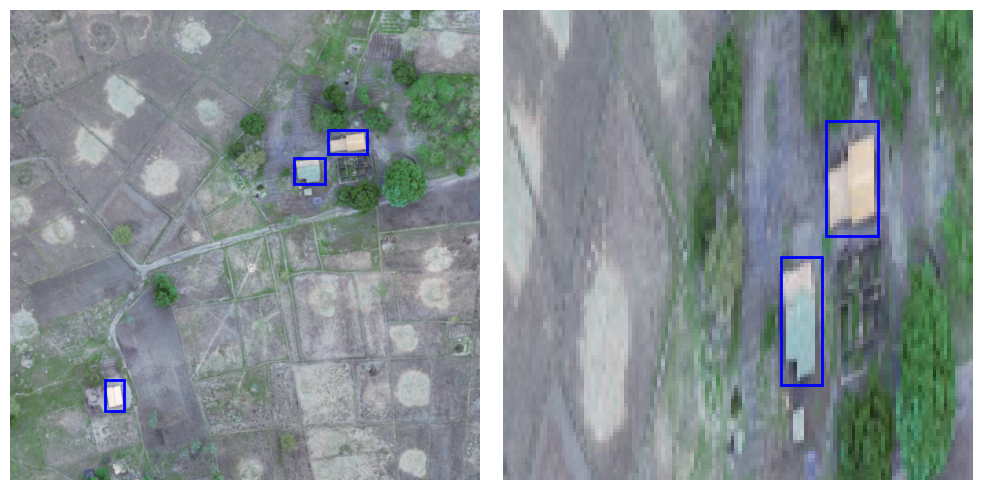

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image)
axs[1].imshow(augemented['image'])

for box in bboxes:
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='blue', facecolor='none')
    axs[0].add_patch(rect)

for box in augemented['bboxes']:
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='blue', facecolor='none')
    axs[1].add_patch(rect)

axs[0].axis('off')
axs[1].axis('off')

plt.tight_layout()

In [30]:
from torch.utils.data import DataLoader, Dataset

def collate_fn(batch):
    return tuple(zip(*batch))

transforms = [
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.ToGray(p=0.01),
    # A.OneOf([
    #     A.imgaug.transforms.IAAAdditiveGaussianNoise(),
    #     A.GaussNoise(),
    # ], p=0.2),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.25),
    A.HueSaturationValue(p=0.25),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.25),
]

train = pd.read_csv(os.path.join(SPLITS_ROOT, 'train_bbox_only_nc.csv'))
dataset = RoofsDataset(IMAGES_ROOT, train, transforms=transforms)
loader = DataLoader(dataset,
                    batch_size=9,
                    shuffle=True,
                    num_workers=1,
                    collate_fn=collate_fn)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
colors = {1 : "red", 2 : "blue", 3 : "yellow"}
for images, targets, rgbs in loader:
    for i in range(9):
        axes[i//3, i%3].imshow(rgbs[i])

        for bbox, category in zip(targets[i]['boxes'], targets[i]['labels']):
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1.5, edgecolor=colors[category.item()], facecolor='none')
            axes[i//3, i%3].add_patch(rect)

    break

In [35]:
a = {
    '1' : torch.Tensor(3),
    '2' : torch.Tensor(1)
}
torch.sum([loss for loss in a.values()])

TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

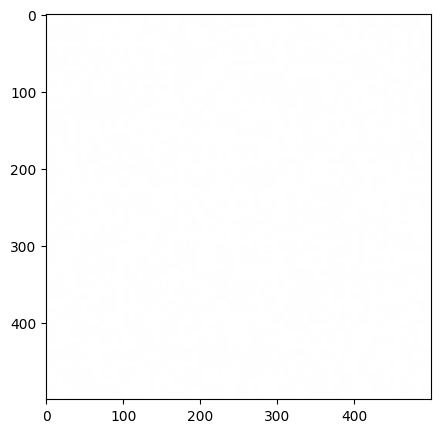

In [25]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
img = cv2.imread(os.path.join(IMAGES_ROOT, "id_a09oswshyaen.tif"))
axes.imshow(img)

In [30]:
import rasterio

In [31]:
a=rasterio.open(os.path.join(IMAGES_ROOT, "id_a09oswshyaen.tif")).read()
print(a.min(), a.max())

253 255


/trinity/home/georgy.popandopulo/.conda/envs/unicef/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [32]:
print(img.min(), img.max())

253 255


In [41]:
def is_image_corrupted(file_name, low_threshold=5, high_threshold=250, corruption_threshold=0.2):
    image = cv2.imread(os.path.join(IMAGES_ROOT, f'{file_name}.tif'))
    low_corrupted = (image < low_threshold).all(axis=-1)
    high_corrupted = (image > high_threshold).all(axis=-1)
    total_corrupted = low_corrupted | high_corrupted
    corruption_mask = low_corrupted | high_corrupted
    
    corrupted_percentage = corruption_mask.astype(np.float32).mean()
    is_corrupted = corrupted_percentage > corruption_threshold
    
    return file_name, is_corrupted, corruption_mask.astype(np.uint8)

df = pd.read_csv('Train.csv')
file_names = np.unique(df.image_id)
with tqdm_joblib(tqdm(desc="Processing", total=file_names.shape[0])) as progress_bar:
    corruption = Parallel(n_jobs=-1)(delayed(is_image_corrupted)(file_name) for file_name in file_names)

Processing:   0%|          | 0/4772 [00:00<?, ?it/s]

In [42]:
corruption = pd.DataFrame(corruption, columns=['image_id', 'is_corrupted', 'mask'])
df = df.join(corruption.set_index('image_id'), on='image_id')

In [84]:
preds = [
   dict(
     boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0], [100.0, 120.0, 140, 160]]),
     scores=torch.tensor([0.536, 0.536]),
     labels=torch.tensor([0, 0]),
   )
]
target = [   dict(
     boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0]]),
     labels=torch.tensor([0]),
   )
]

In [85]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
print(metric.compute())

{'map': tensor(0.6000), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.6000), 'mar_1': tensor(0.6000), 'mar_10': tensor(0.6000), 'mar_100': tensor(0.6000), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.6000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


In [74]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
print(metric.compute())

{'map': tensor(0.6000), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.6000), 'mar_1': tensor(0.3000), 'mar_10': tensor(0.6000), 'mar_100': tensor(0.6000), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.6000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


In [81]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
print(metric.compute())

{'map': tensor(0.7010), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(1.), 'map_large': tensor(0.6000), 'mar_1': tensor(0.3000), 'mar_10': tensor(0.8000), 'mar_100': tensor(0.8000), 'mar_small': tensor(-1.), 'mar_medium': tensor(1.), 'mar_large': tensor(0.6000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


In [79]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
print(metric.compute())

{'map': tensor(0.8020), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(1.), 'map_large': tensor(0.6000), 'mar_1': tensor(0.5000), 'mar_10': tensor(0.8000), 'mar_100': tensor(0.8000), 'mar_small': tensor(-1.), 'mar_medium': tensor(1.), 'mar_large': tensor(0.6000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


In [5]:
img = cv2.imread(f'Images/id_02f9pbs0slgu.tif')

In [12]:
transforms = [
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0, always_apply=True),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.ToGray(p=0.01),
    # A.OneOf([
    #     A.imgaug.transforms.IAAAdditiveGaussianNoise(),
    #     A.GaussNoise(),
    # ], p=0.2),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.25),
    A.HueSaturationValue(p=0.25),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.25),
]
additional_targets = {
    'rgb' : 'mask',
}
transforms = A.Compose(transforms, additional_targets=additional_targets)

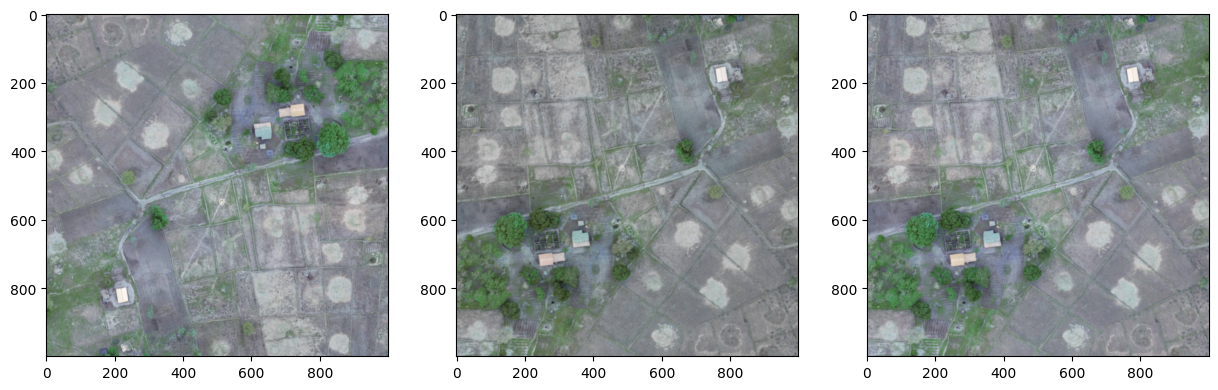

In [13]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
aug = transforms(image=img.copy(), rgb=img.copy())
axes[0].imshow(img)
axes[1].imshow(aug['image'])
axes[2].imshow(aug['rgb'])

In [ ]:
df = pd.read_csv('splits/train_bbox_only_nc.csv')

## Bboxes dist

In [7]:
train_df = pd.read_csv('data/Train.csv')
df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')
group = grouped_df.get_group('id_030hekikfdhm')

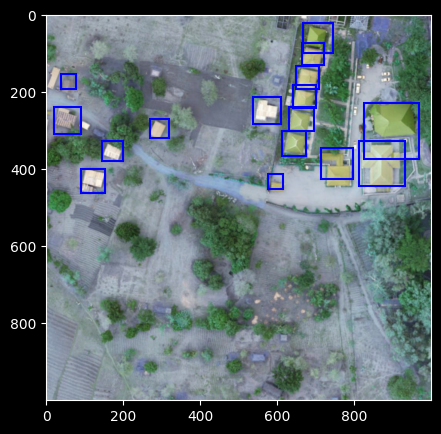

In [8]:
fig, axes = plt.subplots(1,1,figsize=(5,5))

img_id = group.iloc[0].image_id
img = cv2.imread(os.path.join(IMAGES_ROOT, f'{img_id}.tif'))
axes.imshow(img)

bboxes = group.bbox.apply(eval).tolist()
for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[2], linewidth=1.5, edgecolor='blue', facecolor='none')
    axes.add_patch(rect)

In [9]:
group

image_id                          bbox  category_id    id
304    id_030hekikfdhm     [39.0, 153.0, 38.0, 60.0]          2.0  18.0
1060   id_030hekikfdhm    [575.0, 412.0, 39.0, 52.0]          2.0  17.0
2067   id_030hekikfdhm     [21.0, 239.0, 68.0, 61.0]          2.0  15.0
5458   id_030hekikfdhm  [813.0, 326.0, 118.0, 129.0]          2.0   5.0
5768   id_030hekikfdhm    [642.0, 181.0, 59.0, 78.0]          2.0   9.0
6114   id_030hekikfdhm    [648.0, 130.0, 61.0, 75.0]          2.0  10.0
7123   id_030hekikfdhm    [538.0, 211.0, 71.0, 87.0]          2.0  16.0
9104   id_030hekikfdhm    [611.0, 300.0, 64.0, 68.0]          2.0   7.0
9400   id_030hekikfdhm     [663.0, 71.0, 58.0, 84.0]          2.0  11.0
10996  id_030hekikfdhm    [269.0, 269.0, 50.0, 51.0]          2.0  12.0
13326  id_030hekikfdhm    [631.0, 237.0, 64.0, 79.0]          2.0   8.0
20142  id_030hekikfdhm    [146.0, 326.0, 52.0, 50.0]          2.0  13.0
21679  id_030hekikfdhm   [824.0, 228.0, 145.0, 89.0]          2.0   4.0
22067  id_030hekikfdhm     [666.0, 19.0, 78.0, 73.0]          2.0  19.0
22818  id_030hekikfdhm     [90.0, 399.0, 62.0, 52.0]          2.0  14.0
24684  id_030hekikfdhm   [713.0, 343.0, 83.0, 109.0]          2.0   6.0

In [11]:
from PIL import Image, ImageDraw

category_color_map = {1 : "red", 2 : "blue", 3 : "green"}
category_name_map =  {1 : "Other", 2 : "Tin", 3 : "Thatch"}

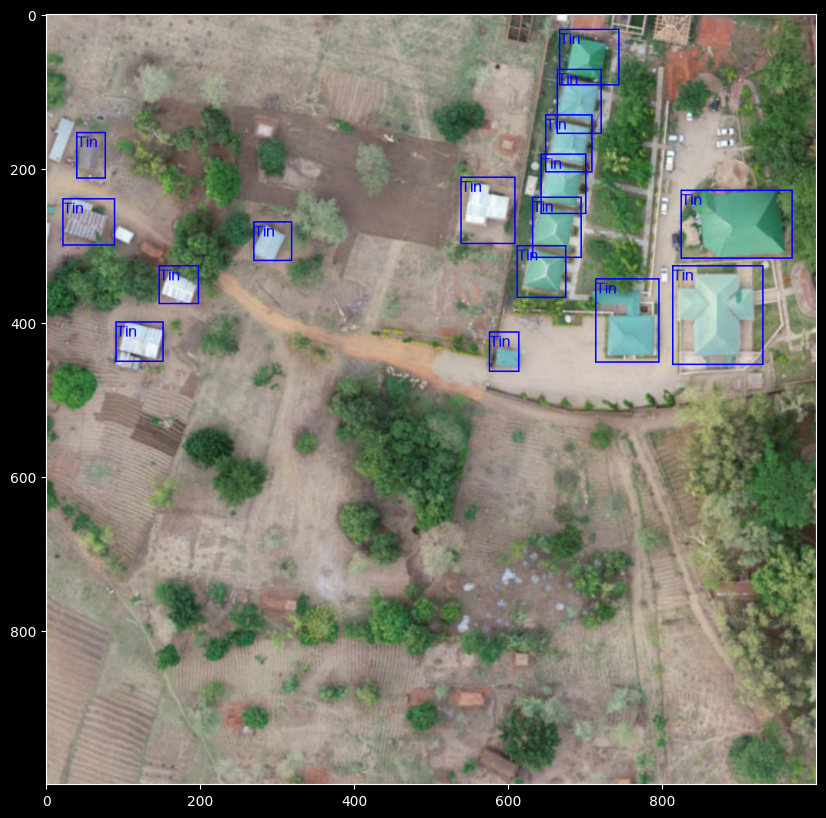

In [21]:
image = Image.open(os.path.join(IMAGES_ROOT, f'{img_id}.tif')).convert('RGB')

bboxes = group.bbox.apply(eval).tolist()
cats = group.category_id.apply(int).to_list()
draw = ImageDraw.Draw(image, "RGB")

for box, cat in zip(bboxes, cats):
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline=category_color_map[cat], width=2)
  draw.text((x, y), category_name_map[cat], fill=category_color_map[cat], font_size=20)

fig, axes = plt.subplots(1,1,figsize=(10,10))
axes.imshow(np.array(image))

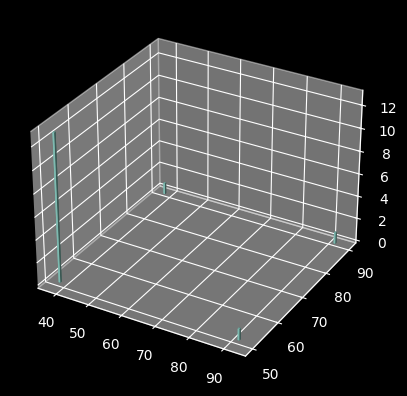

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
bboxes = np.array(bboxes)
hist, xedges, yedges = np.histogram2d(bboxes[:, 2], bboxes[:, 3], bins=2)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

(array([4., 1., 3.]),
 array([2028., 2877., 3726., 4575.]),
 <BarContainer object of 3 artists>)

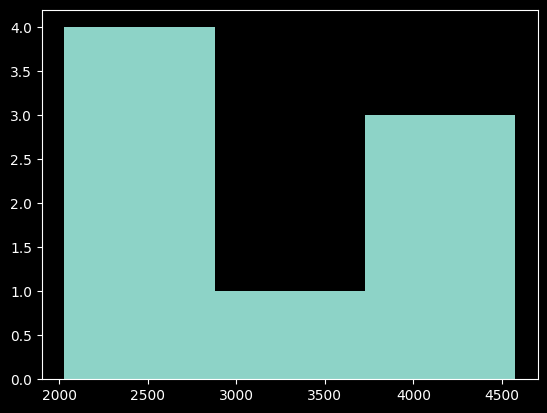

In [41]:
areas = bboxes[:,2]*bboxes[:,3]
areas = areas[areas < np.median(areas)]
plt.hist(areas, bins=3)

In [35]:
np.median(bboxes[:,2]*bboxes[:,3])

4588.5

In [95]:
train_df = pd.read_csv('Train.csv')
df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')

mean_areas = pd.DataFrame(columns=['image_id', 'area'])
mean_areas.set_index('image_id', inplace=True)

for key, item in grouped_df:
    group = grouped_df.get_group(key)
    bboxes = np.array(group.bbox.apply(eval).tolist())
    areas = bboxes[:, 2] * bboxes[:, 3]

    subset = pd.DataFrame(data={'image_id': [key], 'area': [np.mean(areas)]})
    subset.set_index('image_id', inplace=True)  
    mean_areas = pd.concat([mean_areas, subset])

/tmp/ipykernel_2352869/1941692173.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_areas = pd.concat([mean_areas, subset])


In [117]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [111]:
ids = mean_areas[np.logical_and(np.log(mean_areas.area) >=  6.44512107, np.log(mean_areas.area) >= 9.21780141)]

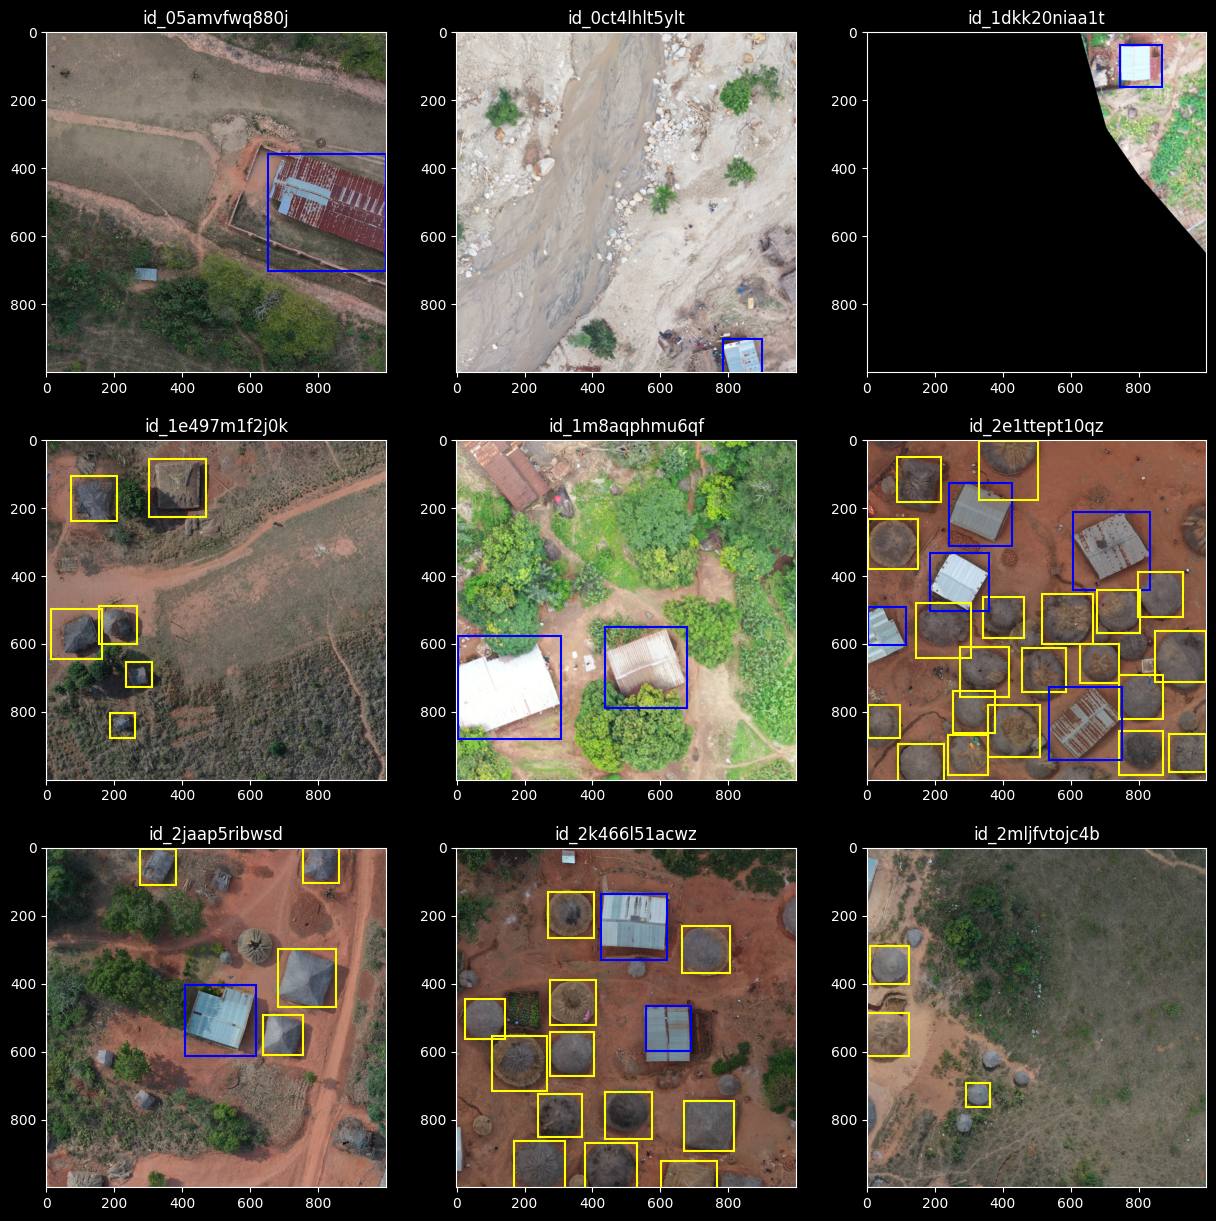

In [112]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
colors = {1 : "red", 2 : "blue", 3 : "yellow"}

for i, key in enumerate(ids.index):
    group = grouped_df.get_group(key)

    file_name = f"{group.iloc[0].image_id}.tif"
    image = rasterio.open(os.path.join(IMAGES_ROOT, file_name)).read().transpose((1,2,0))

    axes[i//3, i%3].imshow(image)
    axes[i//3, i%3].set_title(group.iloc[0].image_id)
    for j in range(group.shape[0]):
        bbox = eval(group.iloc[j].bbox)
        category = group.iloc[j].category_id

        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[2], linewidth=1.5, edgecolor=colors[category], facecolor='none')
        axes[i//3, i%3].add_patch(rect)

    if i == 8:
        break

(array([ 216., 2118.,  131.]),
 array([ 3.67244073,  6.44512107,  9.21780141, 11.99048175]),
 <BarContainer object of 3 artists>)

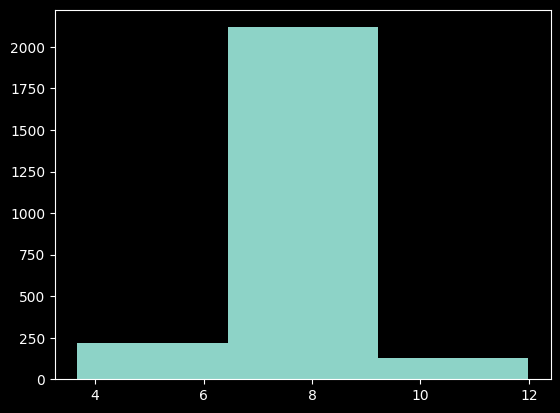

In [85]:
mean_areas = np.array(mean_areas)
mean_areas = mean_areas[mean_areas>0]
plt.hist(np.log(mean_areas), bins=3)

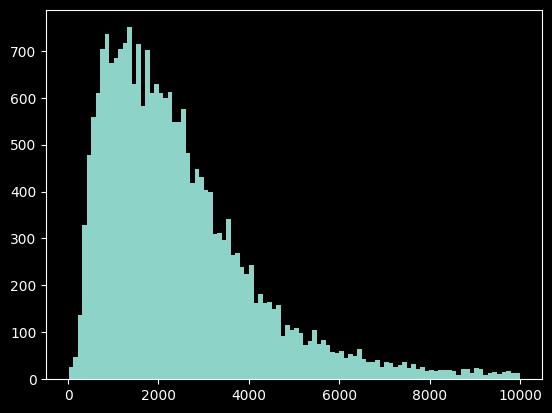

In [60]:
_ = plt.hist(areas[np.logical_and(areas < 10000, areas > 0)], bins=100)

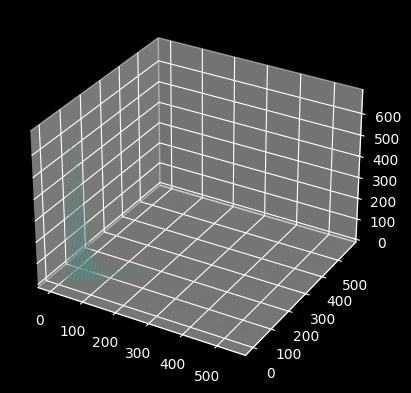

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
bboxes = np.array(bboxes)
hist, xedges, yedges = np.histogram2d(bboxes[:, 2], bboxes[:, 3], bins=100)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.autoscale(enable=True, axis='x', tight=True)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, alpha=0.7, zsort='average')

plt.show()

## DETR

In [7]:
from src.data.datasets import RoofsDataset_DETR
from src.data.utils import collate_fn_detr

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

In [13]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_loader_params = {
    "root"        : IMAGES_ROOT,
    "annotation"  : os.path.join(SPLITS_ROOT, 'test_launch.json'),
    "phase"       : "train",
    "batch_size"  : 2, 
    "collate_fn"  : collate_fn_detr(processor),
    "transforms"  : [],
    "processor"   : processor,
    "cpu"         : True
}
loader = RoofsDataset_DETR.get_dataloader(**train_loader_params)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [30]:
from src.data.datasets import RoofsDataset
from src.data.utils import to_coco_annotation
from PIL import Image

dataset = RoofsDataset(**train_loader_params)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [49]:
img, rgb, nd_mask, bboxes, categories = dataset[0]

annotation = to_coco_annotation(0, bboxes, categories)
img = Image.fromarray(np.uint8(img))
rgb = torch.from_numpy(rgb.astype(np.uint8))
nd_mask = torch.from_numpy(nd_mask).to(torch.uint8)


target = {'image_id': 0, 'annotations': annotation}
encoding = processor(images=img, annotations=target, return_tensors="pt")

features = encoding["pixel_values"].squeeze()
# features = torch.from_numpy(features)
targets = encoding["labels"][0]

In [37]:
torch.tensor(bboxes)

tensor([[545., 435.,  65.,  65.],
        [ 74., 445.,  70.,  68.],
        [569., 696.,  44.,  48.],
        [856.,  93.,  50.,  39.],
        [771., 805.,  40.,  41.],
        [848.,  24.,  35.,  42.],
        [217.,  20.,  52.,  59.],
        [138.,  17.,  38.,  61.],
        [923., 410.,  51.,  51.],
        [225., 624.,  31.,  43.],
        [309., 244.,  83.,  87.],
        [590., 556.,  59.,  47.],
        [719., 750.,  44.,  52.],
        [658., 851.,  27.,  49.],
        [ 17., 442.,  55.,  50.],
        [792., 364.,  36.,  53.],
        [662., 541.,  48.,  39.],
        [ 29., 342.,  43.,  27.],
        [522., 532.,  70.,  56.]], dtype=torch.float64)

In [44]:
targets

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), 'boxes': tensor([[0.5775, 0.4675, 0.0650, 0.0650],
        [0.1090, 0.4790, 0.0700, 0.0680],
        [0.5910, 0.7200, 0.0440, 0.0480],
        [0.8810, 0.1125, 0.0500, 0.0390],
        [0.7910, 0.8255, 0.0400, 0.0410],
        [0.8655, 0.0450, 0.0350, 0.0420],
        [0.2430, 0.0495, 0.0520, 0.0590],
        [0.1570, 0.0475, 0.0380, 0.0610],
        [0.9485, 0.4355, 0.0510, 0.0510],
        [0.2405, 0.6455, 0.0310, 0.0430],
        [0.3505, 0.2875, 0.0830, 0.0870],
        [0.6195, 0.5795, 0.0590, 0.0470],
        [0.7410, 0.7760, 0.0440, 0.0520],
        [0.6715, 0.8755, 0.0270, 0.0490],
        [0.0445, 0.4670, 0.0550, 0.0500],
        [0.8100, 0.3905, 0.0360, 0.0530],
        [0.6860, 0.5605, 0.0480, 0.0390],
        [0.0505, 0.3555, 0.0430, 0.0270],
        [0.5570, 0.5600, 0.0700, 0.0560]]), 'area': tensor([2704.0000, 3046.3999, 1351.6799, 1248.

In [53]:
orig_target_sizes = torch.stack([target["orig_size"] for target in [targets]], dim=0)
# targets = [t + {'logits' : torch.ones_like(t['class_labels'])} for t in [targets]]
processor.post_process_object_detection([targets], target_sizes=orig_target_sizes)

AttributeError: 'list' object has no attribute 'logits'

In [42]:
(targets['boxes'][:, :2] - targets['boxes'][:, 2:] / 2) * 1000

tensor([[544.9999, 435.0000],
        [ 74.0000, 445.0000],
        [568.9999, 696.0001],
        [856.0000,  93.0000],
        [771.0000, 805.0000],
        [848.0001,  24.0000],
        [217.0000,  20.0000],
        [138.0000,  17.0000],
        [923.0001, 410.0000],
        [225.0000, 624.0000],
        [309.0000, 244.0000],
        [590.0000, 556.0001],
        [719.0001, 750.0001],
        [658.0001, 851.0000],
        [ 17.0000, 442.0000],
        [792.0000, 364.0001],
        [662.0001, 541.0000],
        [ 29.0000, 342.0000],
        [521.9999, 532.0000]])

In [40]:
(torch.tensor(bboxes) + torch.tensor([30,30,0,0])) / targets['boxes']

tensor([[ 995.6710,  994.6524, 1000.0000, 1000.0000],
        [ 954.1284,  991.6493,  999.9999, 1000.0002],
        [1013.5364, 1008.3333, 1000.0005,  999.9994],
        [1005.6754, 1093.3334, 1000.0000, 1000.0001],
        [1012.6422, 1011.5082, 1000.0000, 1000.0003],
        [1014.4425, 1200.0000, 1000.0000, 1000.0000],
        [1016.4610, 1010.1010, 1000.0002, 1000.0000],
        [1070.0637,  989.4737,  999.9999,  999.9999],
        [1004.7443, 1010.3329, 1000.0003,  999.9996],
        [1060.2911, 1013.1681,  999.9999,  999.9993],
        [ 967.1898,  953.0435,  999.9999,  999.9997],
        [1000.8071, 1011.2165,  999.9997, 1000.0007],
        [1010.7961, 1005.1545,  999.9997,  999.9991],
        [1024.5718, 1006.2821, 1000.0011,  999.9997],
        [1056.1797, 1010.7066, 1000.0000, 1000.0000],
        [1014.8148, 1008.9628, 1000.0005, 1000.0002],
        [1008.7463, 1018.7332, 1000.0009, 1000.0006],
        [1168.3168, 1046.4134, 1000.0000,  999.9997],
        [ 991.0234, 1003.571

In [14]:
network = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm", num_labels=3, ignore_mismatched_sizes=True)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for features, targets, rgbs, nd_masks in loader:

    output = network(pixel_values=features, pixel_mask=None, labels=targets)

    predictions = processor.post_process_object_detection(output, target_sizes=[features.shape[2:]]*2, threshold=0.9)
    # predictions = filtering_by_mask(predictions, nd_masks)
    # predictions = custom_nms(predictions, trash_thr=0.01)

    break

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [54]:
output.loss_dict

{'loss_ce': tensor(1.6796, grad_fn=<NllLoss2DBackward0>),
 'loss_bbox': tensor(0.1353, grad_fn=<DivBackward0>),
 'loss_giou': tensor(0.9425, grad_fn=<DivBackward0>),
 'cardinality_error': tensor(88.)}

In [25]:
targets[0]

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), 'boxes': tensor([[0.5775, 0.4675, 0.0650, 0.0650],
        [0.1090, 0.4790, 0.0700, 0.0680],
        [0.5910, 0.7200, 0.0440, 0.0480],
        [0.8810, 0.1125, 0.0500, 0.0390],
        [0.7910, 0.8255, 0.0400, 0.0410],
        [0.8655, 0.0450, 0.0350, 0.0420],
        [0.2430, 0.0495, 0.0520, 0.0590],
        [0.1570, 0.0475, 0.0380, 0.0610],
        [0.9485, 0.4355, 0.0510, 0.0510],
        [0.2405, 0.6455, 0.0310, 0.0430],
        [0.3505, 0.2875, 0.0830, 0.0870],
        [0.6195, 0.5795, 0.0590, 0.0470],
        [0.7410, 0.7760, 0.0440, 0.0520],
        [0.6715, 0.8755, 0.0270, 0.0490],
        [0.0445, 0.4670, 0.0550, 0.0500],
        [0.8100, 0.3905, 0.0360, 0.0530],
        [0.6860, 0.5605, 0.0480, 0.0390],
        [0.0505, 0.3555, 0.0430, 0.0270],
        [0.5570, 0.5600, 0.0700, 0.0560]]), 'area': tensor([2704.0000, 3046.3999, 1351.6799, 1248.

In [20]:
rgbs.shape

torch.Size([2, 1000, 1000, 3])

In [19]:
predictions[0]

{'scores': tensor([], grad_fn=<IndexBackward0>),
 'labels': tensor([], dtype=torch.int64),
 'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)}

In [115]:
import torch
def collate_fn_detr(batch):
    features = [item[0] for item in batch]
    targets  = [item[1] for item in batch]
    # rgbs     = [item[2] for item in batch]
    # nd_masks = [item[3] for item in batch]

    # features_padded = processor.pad(features, return_tensors="pt")
    # rgbs_padded = processor.pad(features, return_tensors="pt")
    # masks_padded = processor.pad(features, return_tensors="pt")

    return torch.stack(features), targets

loader = DataLoader(train_dataset,
            batch_size=10,
            shuffle=True,
            num_workers=1,
            collate_fn=collate_fn_detr)

In [116]:
for pixel_values, target in loader:
    break

In [119]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            revision="no_timm",
                                                            num_labels=3,
                                                            ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [130]:
r = model(pixel_values, labels=target)

In [132]:
r['logits'].shape[1:]

torch.Size([100, 4])

In [126]:
postprocessed_outputs  =  processor.post_process_object_detection(r,
                                                        target_sizes=[(800, 800)]*10,
                                                        threshold=0.9)


In [128]:
postprocessed_outputs

[{'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)},
 {'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': te

In [91]:
pixel_values, target = train_dataset[0]

In [99]:
pixel_values.shape

torch.Size([3, 800, 800])

In [100]:
encoding = processor.pad([pixel_values], return_tensors="pt")

In [103]:
encoding['pixel_mask'].shape

torch.Size([1, 800, 800])

In [59]:
image_ids = []
for x in dataset.__getitem__(0)[1]:
    image_ids.append(x['image_id'])

np.unique(image_ids)

array([0])

In [60]:
dataset.__getitem__(0)[1]

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [122.0, 1.0, 42.0, 30.0],
  'area': 1260.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 692,
  'image_id': 0,
  'category_id': 2,
  'bbox': [218.0, 112.0, 45.0, 44.0],
  'area': 1980.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 1417,
  'image_id': 0,
  'category_id': 2,
  'bbox': [74.0, 286.0, 33.0, 30.0],
  'area': 990.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2122,
  'image_id': 0,
  'category_id': 2,
  'bbox': [469.0, 182.0, 29.0, 26.0],
  'area': 754.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2286,
  'image_id': 0,
  'category_id': 2,
  'bbox': [409.0, 444.0, 44.0, 54.0],
  'area': 2376.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2299,
  'image_id': 0,
  'category_id': 2,
  'bbox': [307.0, 311.0, 48.0, 35.0],
  'area': 1680.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2768,
  'image_id': 0,
  'category_id': 2,
  'bbox': [0.0, 184.0, 22.0, 34.0],
  'area': 748.0,
  'iscrowd': 0,
  'segmentati

In [61]:
from pycocotools.coco import COCO
coco = COCO(os.path.join(SPLITS_ROOT, 'train.json'))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [72]:
small_imgs = [idx for idx in coco.imgs.keys() if coco.loadImgs(idx)[0]['width'] == 500]

In [75]:
coco.loadImgs(0)[0]

{'id': 0, 'file_name': 'id_w55q2qr62fsk.tif', 'width': 500, 'height': 500}

In [71]:
coco.loadImgs(0)[0]

{'id': 0, 'file_name': 'id_w55q2qr62fsk.tif', 'width': 500, 'height': 500}

In [ ]:
def ann_from_coco(ann):
    ids = []
    catregories = []
    bboxes = []

    for obj in ann:
        ids.append(obj['id']) 

In [78]:
a = [[obj[key] for obj in coco.loadAnns(coco.getAnnIds(0))] for key in ['id', 'category_id', 'bbox', 'area']]

In [80]:
ids, categories, bboxes, areas = a

In [ ]:
annotation = []
for i, (category, bbox, area) in zip(categories, bboxes, areas):
    obj = {
        ''
    }
    

In [76]:
coco.loadAnns(coco.getAnnIds(0))

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [122.0, 1.0, 42.0, 30.0],
  'area': 1260.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 692,
  'image_id': 0,
  'category_id': 2,
  'bbox': [218.0, 112.0, 45.0, 44.0],
  'area': 1980.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 1417,
  'image_id': 0,
  'category_id': 2,
  'bbox': [74.0, 286.0, 33.0, 30.0],
  'area': 990.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2122,
  'image_id': 0,
  'category_id': 2,
  'bbox': [469.0, 182.0, 29.0, 26.0],
  'area': 754.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2286,
  'image_id': 0,
  'category_id': 2,
  'bbox': [409.0, 444.0, 44.0, 54.0],
  'area': 2376.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2299,
  'image_id': 0,
  'category_id': 2,
  'bbox': [307.0, 311.0, 48.0, 35.0],
  'area': 1680.0,
  'iscrowd': 0,
  'segmentation': []},
 {'id': 2768,
  'image_id': 0,
  'category_id': 2,
  'bbox': [0.0, 184.0, 22.0, 34.0],
  'area': 748.0,
  'iscrowd': 0,
  'segmentati